In [1]:
# install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *

## Getting set up

In [2]:
comp = 'godaddy-microbusiness-density-forecasting'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
!ls godaddy-microbusiness-density-forecasting

census_starter.csv    test.csv
sample_submission.csv train.csv


Now we can import the stuff we'll need from fastai, set a seed (for reproducibility -- just for the purposes of making this notebook easier to write; I don't recommend doing that in your own analysis however) and check what's in the data:

In [4]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Looking at the data

In [5]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')
sub = pd.read_csv(path/'sample_submission.csv')
print(train.shape, test.shape, sub.shape)
train['istest'] = 0
test['istest'] = 1
raw = pd.concat((train, test)).sort_values(['cfips','row_id']).reset_index(drop=True)
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])
raw['county'] = raw.groupby('cfips')['county'].ffill()
raw['state'] = raw.groupby('cfips')['state'].ffill()
raw["year"] = raw["first_day_of_month"].dt.year
raw["month"] = raw["first_day_of_month"].dt.month
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()
raw['county_i'] = (raw['county'] + raw['state']).factorize()[0]
raw['state_i'] = raw['state'].factorize()[0]
raw['active_mean']= raw.groupby('cfips').active.mean()
raw['microbusiness_density_mean'] = raw.groupby('cfips').microbusiness_density.mean()

(122265, 7) (25080, 3) (25080, 2)


In [6]:
census = pd.read_csv(path/'census_starter.csv').set_index('cfips')
census = census.groupby(level=0).max()

In [7]:
def _get_mean(df,pattern):
    l = [col for col in df.columns if col.startswith(pattern)]
    return df[l].mean(axis=1)

In [8]:
census.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 1001 to 56045
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pct_bb_2017            3142 non-null   float64
 1   pct_bb_2018            3142 non-null   float64
 2   pct_bb_2019            3142 non-null   float64
 3   pct_bb_2020            3141 non-null   float64
 4   pct_bb_2021            3141 non-null   float64
 5   pct_college_2017       3142 non-null   float64
 6   pct_college_2018       3142 non-null   float64
 7   pct_college_2019       3142 non-null   float64
 8   pct_college_2020       3141 non-null   float64
 9   pct_college_2021       3141 non-null   float64
 10  pct_foreign_born_2017  3142 non-null   float64
 11  pct_foreign_born_2018  3142 non-null   float64
 12  pct_foreign_born_2019  3142 non-null   float64
 13  pct_foreign_born_2020  3141 non-null   float64
 14  pct_foreign_born_2021  3141 non-null   float64
 15  

In [9]:

census['median_hh_inc_mean'] = _get_mean(census,'median_hh_inc_')
census['pct_foreign_born_mean'] = _get_mean(census,'pct_foreign_born')
census['pct_college_mean'] = _get_mean(census,'pct_college')
census['pct_it_workers_mean'] = _get_mean(census,'pct_it_workers_')

In [10]:
# census = census.join(state_one_hot.add_prefix('st_'))

In [11]:
census

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021,...,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,median_hh_inc_mean,pct_foreign_born_mean,pct_college_mean,pct_it_workers_mean
cfips,,,,,,,,,,,,,,,,,,,,,
1001,76.6,78.9,80.6,82.7,85.5,14.5,15.9,16.1,16.7,16.4,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1003,74.5,78.1,81.8,85.1,87.9,20.4,20.7,21.0,20.2,20.6,...,1.3,52562,55962.0,58320,61756.0,64346.0,58589.2,3.44,20.58,1.28
1005,57.2,60.4,60.5,64.6,64.6,7.6,7.8,7.6,7.3,6.7,...,0.8,33368,34186.0,32525,34990.0,36422.0,34298.2,2.62,7.40,0.70
1007,62.0,66.1,69.2,76.1,74.6,8.1,7.6,6.5,7.4,7.9,...,2.1,43404,45340.0,47542,51721.0,54277.0,48456.8,1.32,7.50,1.60
1009,65.8,68.5,73.0,79.6,81.0,8.7,8.1,8.6,8.9,9.3,...,0.9,47412,48695.0,49358,48922.0,52830.0,49443.4,4.46,8.72,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,82.2,82.4,84.0,86.7,88.4,15.3,15.2,14.8,13.7,12.4,...,1.0,71083,73008.0,74843,73384.0,76668.0,73797.2,5.14,14.28,0.82
56039,83.5,85.9,87.1,89.1,90.5,37.7,37.8,38.9,37.2,38.3,...,2.0,80049,83831.0,84678,87053.0,94498.0,86021.8,11.26,37.98,1.36
56041,83.8,88.2,89.5,91.4,90.6,11.9,10.5,11.1,12.6,12.3,...,0.9,54672,58235.0,63403,72458.0,75106.0,64774.8,2.94,11.68,1.28


## Feature engineering

In [12]:
dep='microbusiness_density'

In [13]:
 def build_lag_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [366]:
def _select_cols(df):
    ft_cols=['pct_foreign_born_mean','pct_college_mean','pct_it_workers_mean','median_hh_inc_mean'
              ,'year'
             ,'month'
             ,'county_i'
#              ,'state_i'
#              ,'first_day_of_month'
#              ,'active_mean','microbusiness_density_mean'
            
             ]
    l = [[col for col in df.columns if col.startswith(pattern)] for pattern in ft_cols]
    flat_list = [item for sublist in l for item in sublist]
    return df[flat_list]

def feature_engineering(df):
    df['year'] = df.first_day_of_month.dt.year
    df['month'] = df.first_day_of_month.dt.month
    df = df.set_index(['cfips'])
    df = df.join(census)
#     return df
    return df



df_ft = feature_engineering(raw)
# proc_data(tst_df)

In [367]:

def xs_y(df):
    # df[cats] = df[cats].apply(lambda x: x.cat.codes)
    xs = df[set(df.columns)-set([dep])].fillna(0)
    return _select_cols(xs),df[dep] if dep in df else None

# trn_xs,trn_y = xs_y(trn_df)
# val_xs,val_y = xs_y(val_df)

In [368]:
df_ft.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147345 entries, 1001 to 56045
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   row_id                      147345 non-null  object        
 1   county                      147345 non-null  object        
 2   state                       147345 non-null  object        
 3   first_day_of_month          147345 non-null  datetime64[ns]
 4   microbusiness_density       122265 non-null  float64       
 5   active                      122265 non-null  float64       
 6   istest                      147345 non-null  int64         
 7   year                        147345 non-null  int64         
 8   month                       147345 non-null  int64         
 9   dcount                      147345 non-null  int64         
 10  county_i                    147345 non-null  int64         
 11  state_i                     147345 no

In [369]:
df_ft.head(3)

,row_id,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,...,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,median_hh_inc_mean,pct_foreign_born_mean,pct_college_mean,pct_it_workers_mean
cfips,,,,,,,,,,,,,,,,,,,,,
1001,1001_2019-08-01,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1001,1001_2019-09-01,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1001,1001_2019-10-01,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96


In [370]:
# m = DecisionTreeClassifier(min_samples_leaf=50)
# m.fit(trn_xs, trn_y)
# draw_tree(m, trn_xs, size=25)

## Our first model

In [371]:
df_ft.reset_index().year.drop_duplicates()

0     2019
5     2020
17    2021
29    2022
41    2023
Name: year, dtype: int64

In [372]:
df_ft.dtypes

row_id                                object
county                                object
state                                 object
first_day_of_month            datetime64[ns]
microbusiness_density                float64
active                               float64
istest                                 int64
year                                   int64
month                                  int64
dcount                                 int64
county_i                               int64
state_i                                int64
active_mean                          float64
microbusiness_density_mean           float64
pct_bb_2017                          float64
pct_bb_2018                          float64
pct_bb_2019                          float64
pct_bb_2020                          float64
pct_bb_2021                          float64
pct_college_2017                     float64
pct_college_2018                     float64
pct_college_2019                     float64
pct_colleg

In [397]:
val_set = list(df_ft[df_ft.istest==0].first_day_of_month.drop_duplicates().sort_values().tail(3))

In [398]:
val_set

[Timestamp('2022-08-01 00:00:00'),
 Timestamp('2022-09-01 00:00:00'),
 Timestamp('2022-10-01 00:00:00')]

In [399]:
from sklearn.model_selection import train_test_split
# trn_df,val_df = train_test_split(df_ft, test_size=0.25)
trn_df = df_ft[(~df_ft.first_day_of_month.isin(val_set))&(df_ft.istest==0)].drop('first_day_of_month',axis=1)
val_df = df_ft[df_ft.first_day_of_month.isin(val_set)&(df_ft.istest==0)].drop('first_day_of_month',axis=1)

In [400]:
val_df.year.unique()

array([2022])

In [401]:
trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_24404/56242654.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)
/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_24404/56242654.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)


In [402]:
trn_y.head(5)

cfips
1001    3.007682
1001    2.884870
1001    3.055843
1001    2.993233
1001    2.993233
Name: microbusiness_density, dtype: float64

In [403]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112860 entries, 1001 to 56045
Data columns (total 42 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   row_id                      112860 non-null  object 
 1   county                      112860 non-null  object 
 2   state                       112860 non-null  object 
 3   microbusiness_density       112860 non-null  float64
 4   active                      112860 non-null  float64
 5   istest                      112860 non-null  int64  
 6   year                        112860 non-null  int64  
 7   month                       112860 non-null  int64  
 8   dcount                      112860 non-null  int64  
 9   county_i                    112860 non-null  int64  
 10  state_i                     112860 non-null  int64  
 11  active_mean                 2396 non-null    float64
 12  microbusiness_density_mean  2396 non-null    float64
 13  pct_bb_2017 

In [404]:
_select_cols(trn_df)

,pct_foreign_born_mean,pct_college_mean,pct_it_workers_mean,median_hh_inc_mean,year,month,county_i
cfips,,,,,,,
1001,2.16,15.92,0.96,58695.2,2019,8,0
1001,2.16,15.92,0.96,58695.2,2019,9,0
1001,2.16,15.92,0.96,58695.2,2019,10,0
1001,2.16,15.92,0.96,58695.2,2019,11,0
1001,2.16,15.92,0.96,58695.2,2019,12,0
...,...,...,...,...,...,...,...
56045,2.70,13.52,0.24,57680.4,2022,3,3134
56045,2.70,13.52,0.24,57680.4,2022,4,3134
56045,2.70,13.52,0.24,57680.4,2022,5,3134


In [405]:
val_xs.head(5)

,pct_foreign_born_mean,pct_college_mean,pct_it_workers_mean,median_hh_inc_mean,year,month,county_i
cfips,,,,,,,
1001,2.16,15.92,0.96,58695.2,2022,8,0
1001,2.16,15.92,0.96,58695.2,2022,9,0
1001,2.16,15.92,0.96,58695.2,2022,10,0
1003,3.44,20.58,1.28,58589.2,2022,8,1
1003,3.44,20.58,1.28,58589.2,2022,9,1


In [406]:
import xgboost as xgb

model = xgb.XGBRegressor(booster='gbtree',eval_metric='rmse', random_state=42, n_estimators=5000,max_depth=300)
# rf = RandomForestRegressor(20, min_samples_leaf=5)
model.fit(trn_xs, trn_y);

In [407]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    actual = np.array(actual)
    predicted = np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

In [408]:
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
print(mean_absolute_error(val_y, model.predict(val_xs)))
print(calculate_smape(val_y, model.predict(val_xs)))
#0.1345,0.33
#2.27,2.23

0.13411065219235
2.26


In [409]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=model.feature_importances_)).sort_values('imp')

,cols,imp
5,month,0.012252
0,pct_foreign_born_mean,0.082549
4,year,0.116716
2,pct_it_workers_mean,0.123041
3,median_hh_inc_mean,0.125423
6,county_i,0.175818
1,pct_college_mean,0.364201


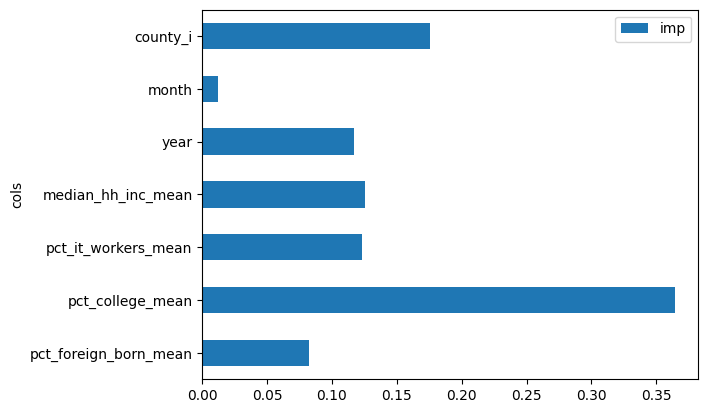

In [410]:
pd.DataFrame(dict(cols=val_xs.columns, imp=model.feature_importances_)).plot('cols', 'imp', 'barh');

## Submitting to Kaggle

In [411]:
test_df = df_ft[df_ft.istest==1].drop('first_day_of_month',axis=1)

In [412]:
test_df

,row_id,county,state,microbusiness_density,active,istest,year,month,dcount,county_i,...,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,median_hh_inc_mean,pct_foreign_born_mean,pct_college_mean,pct_it_workers_mean
cfips,,,,,,,,,,,,,,,,,,,,,
1001,1001_2022-11-01,Autauga County,Alabama,NaN,NaN,1,2022,11,39,0,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1001,1001_2022-12-01,Autauga County,Alabama,NaN,NaN,1,2022,12,40,0,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1001,1001_2023-01-01,Autauga County,Alabama,NaN,NaN,1,2023,1,41,0,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1001,1001_2023-02-01,Autauga County,Alabama,NaN,NaN,1,2023,2,42,0,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
1001,1001_2023-03-01,Autauga County,Alabama,NaN,NaN,1,2023,3,43,0,...,1.1,55317,58786.0,58731,57982.0,62660.0,58695.2,2.16,15.92,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56045,56045_2023-02-01,Weston County,Wyoming,NaN,NaN,1,2023,2,42,3134,...,0.0,59605,52867.0,57031,53333.0,65566.0,57680.4,2.70,13.52,0.24
56045,56045_2023-03-01,Weston County,Wyoming,NaN,NaN,1,2023,3,43,3134,...,0.0,59605,52867.0,57031,53333.0,65566.0,57680.4,2.70,13.52,0.24
56045,56045_2023-04-01,Weston County,Wyoming,NaN,NaN,1,2023,4,44,3134,...,0.0,59605,52867.0,57031,53333.0,65566.0,57680.4,2.70,13.52,0.24


In [413]:
test_xs = xs_y(test_df)[0]

/var/folders/5x/sh4xsr052rvdh1ft462t40fr0000gn/T/ipykernel_24404/56242654.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xs = df[set(df.columns)-set([dep])].fillna(0)


In [414]:
test_xs

,pct_foreign_born_mean,pct_college_mean,pct_it_workers_mean,median_hh_inc_mean,year,month,county_i
cfips,,,,,,,
1001,2.16,15.92,0.96,58695.2,2022,11,0
1001,2.16,15.92,0.96,58695.2,2022,12,0
1001,2.16,15.92,0.96,58695.2,2023,1,0
1001,2.16,15.92,0.96,58695.2,2023,2,0
1001,2.16,15.92,0.96,58695.2,2023,3,0
...,...,...,...,...,...,...,...
56045,2.70,13.52,0.24,57680.4,2023,2,3134
56045,2.70,13.52,0.24,57680.4,2023,3,3134
56045,2.70,13.52,0.24,57680.4,2023,4,3134


In [415]:
test_df['microbusiness_density'] = model.predict(test_xs)

In [416]:
result = test_df[['row_id','microbusiness_density']]

In [417]:
result.to_csv('subm.csv', index=False)
!head subm.csv

row_id,microbusiness_density
1001_2022-11-01,3.3694215
1001_2022-12-01,3.4145334
1001_2023-01-01,3.2971766
1001_2023-02-01,3.3342762
1001_2023-03-01,3.3368402
1001_2023-04-01,3.3715308
1001_2023-05-01,3.3137374
1001_2023-06-01,3.3464553
1003_2022-11-01,8.514135


Let's submit this to kaggle. We can do it from the notebook if we're running on Kaggle, otherwise we can use the API:

In [419]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli('subm.csv', 'xgb_updated_v2', comp)

100%|█████████████████████████████████████████| 653k/653k [00:02<00:00, 297kB/s]


Success! We successfully created a submission.

## Conclusion

## Addendum

`fastkaggle` also provides a function that pushes a notebook to Kaggle Notebooks. I wrote this notebook on my own machine, and pushed it to Kaggle from there -- here's the command I used:

In [42]:
if not iskaggle:
    push_notebook('madhaowagh', 'xgb_model_v2',
                  title='initial notebook ',
                  file='xgb_model_v1.ipynb',
                  competition=comp, private=False, gpu=False)

Your kernel title does not resolve to the specified id. This may result in surprising behavior. We suggest making your title something that resolves to the specified id. See https://en.wikipedia.org/wiki/Clean_URL#Slug for more information on how slugs are determined.
Kernel version 1 successfully pushed.  Please check progress at https://www.kaggle.com/code/madhaowagh/initial-notebook
